
## `Лабораторная работа №3 "Задачи NLP"`



#### Фамилия, имя:

Дата выдачи: <span style="color:red">__11 декабря__</span>.

Срок сдачи: <span style="color:red">__25 декабря__</span>.

Максимальная оценка: __10 баллов__




## `Задание 1. Классификация текста с помощью RNN (5 баллов)`



[Данные](https://drive.google.com/drive/folders/1epWf0Wwixxv9juicjdCYYVz351vEe9yM?usp=drive_link) представляют собой тексты разных авторов. Обучающий набор содержит текст - его автора (метку к нему), всего 8 авторов. Тестовый набор содержит только тексты.

Необходимо решить задачу многоклассовой классификации текстов по авторам.

In [ ]:
# загрузим данные
!gdown --folder https://drive.google.com/drive/folders/1epWf0Wwixxv9juicjdCYYVz351vEe9yM?usp=drive_link

Retrieving folder contents
Processing file 1U9L5hXUDWIBdzvTWCyi-UBxHsfbqBmPH test_authors.csv
Processing file 1zfjcjc0S_9DQWZ1MCftKdF9iPct89vFx train_authors.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1U9L5hXUDWIBdzvTWCyi-UBxHsfbqBmPH
To: /content/Text_Author/test_authors.csv
100% 962k/962k [00:00<00:00, 9.20MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zfjcjc0S_9DQWZ1MCftKdF9iPct89vFx
To: /content/Text_Author/train_authors.csv
100% 5.16M/5.16M [00:00<00:00, 21.9MB/s]
Download completed


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk
from tqdm import tqdm_notebook
import torch.nn as nn
import torch.nn.functional as F

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Подготовка данных

Загрузим датасет и посмотрим на данные:

In [ ]:
import pandas as pd
train_data = pd.read_csv('train_authors.csv')
train_data.head()

,text,author
0,"Студент, который все это нам рассказал, прилет...",Bulychev
1,"-Что не укладывается в голове,- произнес отец ...",Pratchett
2,"-Ш-ш-ш,- сказал я.- Спи.\n-Не могу,- ответила ...",King
3,-В Севастополь? Новое задание имеет отношение ...,Akunin
4,"-Ты прав,- сказал Сева.- Даже если это космиче...",Bulychev


In [ ]:
test_data = pd.read_csv('test_authors.csv')
test_data.head()

,text
0,-Не выглядывал еще. Дрыхнет… Почему да почему?...
1,"Идти ему было немного; он даже знал, сколько ш..."
2,Придется вернуться в самое изголовье и начать ...
3,"-С ума сойти,- сказал отец. Он обернулся, увид..."
4,"Во-вторых, положение Петра после захвата власт..."


In [ ]:
# Назначим каждому автору идентификатор
writers = ['Akunin', 'Bulychev', 'Chehov', 'Dostoevsky', 'Gogol', 'King',
          'Pratchett', 'Remark']
writers_to_label = {writer: i for i, writer in enumerate(writers)}
label_to_writers = {i: writer for i, writer in enumerate(writers)}

Подготовим данные для задачи классификации текстов по авторам, преобразуя сырые данные в словарь dataset['train'] и dataset['test'].


In [ ]:
dataset = {}

dataset['train'] = [{'text':text, 'author':writers_to_label[label]} \
              for text, label in zip(np.array(train_data['text']), np.array(train_data['author']))]
dataset['test'] = [{'text':text, 'author': 0} \
              for text in np.array(test_data['text'])]

Можно сделать иначе используя класс `Dataset`.


In [ ]:
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, texts, authors):
        self.texts = texts
        self.authors = authors

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {'text': self.texts[idx], 'author': self.authors[idx]}

**1)** Заведите Dataloader для загрузки данных нейронную сеть.

**2)** Разработайте и обучите RNN  на тренировочных данных.

Вкачестве рекуррентных слоёв можно выбрать:
- базовый RNN,
- LSTM,
- GRU,
- Применение двунаправленных рекуррентных слоев (Bidirectional RNN/LSTM/GRU).

**3)** Проведите эксперитенты с:
- Увеличением глубины модели. Используйте параметр `num_layers` для создания многослойной RNN.
При этом выходы каждого предыдущего слоя передаются в качестве входов следующему.

- Агрегацией выходных последовательностей. Помимо стандартных подходов (max, mean, last), рассмотрите, например, конкатенацию различных видов агрегации, использование различных пулинговых операций, или Ваш вариант.

**4)** Сделайте выводы и выберите модель с лучшей accuracy.

### Инференс модели

Ниже функция для оценки точности модели на данных из DataLoader.

Здесь model — ваша обученная модель, dataloader — test_dataloader, построенный на основе тестовой части данных (dataset['test']).

In [ ]:
def get_predictions(model, dataloader):
    """
    Calculate accuracy on data from dataloader.
    """

    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm_notebook(dataloader,
                                   desc=f'Evaluating'):
            # Получаем предсказания
            logits = model(batch['input_ids'])
             # Для многоклассовой классификации
            predictions.append(logits.argmax(dim=1))

    predictions = torch.cat(predictions).data.cpu().numpy()

    return predictions

In [ ]:
predictions = get_predictions(model, test_dataloader)
predictions = [label_to_writers[x] for x in predictions]
predictions

### Сохраните результат

In [ ]:
np.save('submission_rnn03.npy', predictions, allow_pickle=True)
print('Ответ сохранен в файл `submission_rnn03.npy`')

## `Задание 2. Классификация текста с помощью предобученной языковой модели BERT (3 балла)`

Рассматривается [датасет](https://drive.google.com/drive/folders/151O9W-yp6TMP0Wmrm_wzbu8F7sq4cm_4?usp=sharing)
**SST-2** (Stanford Sentiment Treebank версии 2).


In [ ]:
import os
import random

import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython.display import clear_output

### Загрузка данных


`holdout_texts.npy` - файл содержит holdout выборку.

holdout выборка - это отдельная часть неразмеченных данных, которая НЕ используется при обучении модели и служит исключительно для финальной оценки её качества после завершения всех экспериментов.

`STT2_train_task.tsv` - файл с обучающей выборкой.


In [ ]:
# загрузим данные
!gdown --folder https://drive.google.com/drive/folders/151O9W-yp6TMP0Wmrm_wzbu8F7sq4cm_4?usp=sharing

Retrieving folder contents
Processing file 1ifRDFC5b9V08XzWo1my7XCCGh_ji3jt1 holdout_texts.npy
Processing file 1k-dMMYNPqOjeppDoTWd7nR3Ln2VI0ZVv STT2_train_task.tsv.txt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1ifRDFC5b9V08XzWo1my7XCCGh_ji3jt1
To: /content/SST2/holdout_texts.npy
100% 45.4k/45.4k [00:00<00:00, 41.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1k-dMMYNPqOjeppDoTWd7nR3Ln2VI0ZVv
To: /content/SST2/STT2_train_task.tsv.txt
100% 720k/720k [00:00<00:00, 7.28MB/s]
Download completed


In [ ]:
# преобразуем holdout-выборку в numpy.array
texts_holdout = np.load('/content/SST2/holdout_texts.npy', allow_pickle=True)
texts_holdout[:5]


array(['gee , a second assassin shot kennedy ?',
       "from the big giant titles of the opening credits to elmer bernstein 's perfectly melodic score , haynes gets just about everything right",
       'the movie is well shot and very tragic , and one to ponder after the credits roll',
       'the movie quickly drags on becoming boring and predictable',
       "a mixed bag of a comedy that ca n't really be described as out of this world"],
      dtype=object)

In [ ]:
# Загрузим обучающие и тестовые размеченные данные
df = pd.read_csv(
    '/content/SST2/STT2_train_task.tsv.txt',
    delimiter='\t',
    header=None
)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6920 entries, 0 to 6919
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       6920 non-null   object
 1   1       6920 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 108.3+ KB


In [ ]:
# реализуем простое разделение на обучающую и тестовую части
# 73% - обучающая, 27% - тестовая
texts_train = df[0].values[:5000]
y_train = df[1].values[:5000]
texts_test = df[0].values[5000:]
y_test = df[1].values[5000:]


**1)** Напишите функцию получения эмбеддингов.

Сначала необходимо получить эмбендинги предложений с помощью обученной `BERT':

- Загрузить предобученный токенизатор и модель.

- Токенизировать текст с добавлением специальных токенов и преобразовать в тензоры.

Функция
`tokenizer.encode(text, add_special_tokens=True)`
возвращает ID токенов.

- Пропустить через модель и получить выходы.

- Извлечь эмбеддинг для всего предложения (возьмем скрытое состояние, соответствующее [CLS] токену).



In [ ]:
def get_bert_embeddings(text, model, tokenizer, pooling_strategy='cls'):
    """
    Получение эмбеддингов текста с помощью BERT

    Args:
        text: строка или список строк
        model: предобученная модель BERT
        tokenizer: токенизатор BERT
        pooling_strategy: стратегия пулинга ('cls', 'mean', 'max')

    Returns:
        Векторное представление текста
    """

      # your code here

**2)** Обучите логистическую регрессию

Датасет для обучения логистической регрессии состоит из векторов, полученных из предобученной модели BERT. В качестве признаков используются эмбеддинги токена [CLS], которые извлекаются из выходного слоя трансформерного блока модели.
Каждая строка датасета соответствует отдельному предложению, а столбцы представляют активации скрытых нейронов полносвязного слоя, следующего за трансформерной архитектурой. Эти векторные представления служат входными признаками для классификатора.

Ваша модель должна давать точность > 80%

In [ ]:
  # your code here


Сохраните в словарь `out_dict` вероятности принадлежности к нулевому и первому классу соответственно, для кадой выборки:

In [ ]:
out_dict = {
    'train': # np.array of size (5000, 2) with probability
    'test': # np.array of size (1920, 2) with probability
    'holdout': # np.array of size (500, 2) with probability
}

### Сохраните результат

In [ ]:
np.save('submission_bert03.npy', out_dict, allow_pickle=True)
print('Ответ сохранен в файл `submission_bert03.npy`')

## `Задание 3. Реализовать механизм внимания (2 балла)`


Рассмотрим архитектуру энкодера-декодера, где энкодер преобразует входную последовательность в набор скрытых состояний $h_{e1}, ..., h_{eN}$, а декодер генерирует выходную последовательность, используя свои состояния $h_{dt}$ в каждый момент времени $t$.


**Вектор внимания** $a_{dt}$ в момент времени $t$ представляет собой распределение важности по всем состояниям энкодера:


$$a_{dt} = [a_{i,t},...,a_{N, t}]$$


где каждый элемент $a_{i, t} = f(h_{ei}, h_{dt})$ вычисляется с помощью функции внимания $f$, оценивающей релевантность $i$-го состояния энкодера текущему состоянию декодера.

**Типы функций внимания**:

1. **Внимание на основе скалярного произведения (Dot-Product Attention)**
Самый простой и вычислительно эффективный подход, непосредственно измеряющий сходство между векторами:

$$f(h_{ei}, h_{dt}) = h_{dt}^Th_{ei}$$

Преимущества:

- Минимальные вычислительные затраты.

- Не требует дополнительных обучаемых параметров.

2. **Мультипликативное внимание (Multiplicative Attention)**

Вводит обучаемую матрицу весов $W$ для моделирования взаимодействий между пространствами энкодера и декодера:

$$f(h_{ei}, h_{dt}) = h_{dt}^T*W*h_{ei}$$

Преимущества:

- Позволяет моделировать более сложные взаимосвязи.

- Матрица $W$ адаптируется в процессе обучения.

- Эффективнее скалярного произведения при разных размерностях векторов.

3. **Аддитивное внимание (Additive Attention)**
Использует двухслойную нейронную сеть с нелинейной активацией (например, tanh) для вычисления оценки внимания:

$$f(h_{ei}, h_{dt}) = v^T*tanh(W_1*h_{ei}+W_2*h_{dt})$$

где $W_1$, $W_2$ — матрицы весов, а $v$ — вектор весов для получения скалярного значения.

Преимущества:

- Более выразительная модель за счет нелинейности.

- Подходит для случаев, когда прямого сходства между векторами недостаточно.



In [ ]:
import os
import random

import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython.display import clear_output


#### Dot product attention (пример реализации)

Рассмотрим единственное состояние энкодера – вектор с размерностью `(n_hidden, 1)`, где `n_hidden = 3` - размерность вектора, который определяет единственное состояние энкодера:

Text(0.5, 1.0, 'Decoder state')

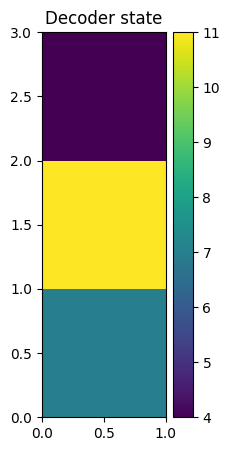

In [ ]:
decoder_hidden_state = np.array([7, 11, 4]).astype(float)[:, None]

plt.figure(figsize=(2, 5))
plt.pcolormesh(decoder_hidden_state)
plt.colorbar()
plt.title('Decoder state')

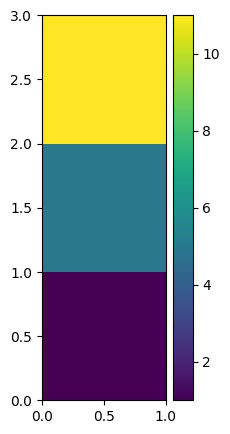

In [ ]:
single_encoder_hidden_state = np.array([1, 5, 11]).astype(float)[:, None]

plt.figure(figsize=(2, 5))
plt.pcolormesh(single_encoder_hidden_state)
plt.colorbar()

In [ ]:
# вектор внимания как скалярное произведение
np.dot(decoder_hidden_state.T, single_encoder_hidden_state)

array([[106.]])

Обобщим на случай, когда у энкодера несколько скрытых состояний:

In [ ]:
encoder_hidden_states = np.array([
    [1, 5, 11],
    [7, 4, 1],
    [8, 12, 2],
    [-9, 0, 1]

]).astype(float).T

encoder_hidden_states

array([[ 1.,  7.,  8., -9.],
       [ 5.,  4., 12.,  0.],
       [11.,  1.,  2.,  1.]])

In [ ]:
# функция подсчета скалярных произведений
def dot_product_attention_score(decoder_hidden_state, encoder_hidden_states):
    '''
    decoder_hidden_state: np.array of shape (n_features, 1)
    encoder_hidden_states: np.array of shape (n_features, n_states)

    return: np.array of shape (1, n_states)
        Array with dot product attention scores
    '''
    attention_scores = np.dot(decoder_hidden_state.T, encoder_hidden_states)
    return attention_scores

In [ ]:
# вектор скрытого состояния
dot_product_attention_score(decoder_hidden_state, encoder_hidden_states)

array([[106.,  97., 196., -59.]])

In [ ]:
#
def softmax(vector):
    '''
    vector: np.array of shape (n, m)

    return: np.array of shape (n, m)
        Matrix where softmax is computed for every row independently
    '''
    nice_vector = vector - vector.max()
    exp_vector = np.exp(nice_vector)
    exp_denominator = np.sum(exp_vector, axis=1)[:, np.newaxis]
    softmax_ = exp_vector / exp_denominator
    return softmax_

In [ ]:
# вектор весов всех состояний
weights_vector = softmax(dot_product_attention_score(decoder_hidden_state, encoder_hidden_states))

weights_vector

array([[8.19401262e-040, 1.01122149e-043, 1.00000000e+000,
        1.79848622e-111]])

**Итоговый вектор внимания** представляет собой взвешенную сумму всех состояний энкодера, где веса определяются релевантностью каждого состояния энкодера текущему состоянию декодера.


In [ ]:
def dot_product_attention(decoder_hidden_state, encoder_hidden_states):
    '''
    decoder_hidden_state: np.array of shape (n_features, 1)
    encoder_hidden_states: np.array of shape (n_features, n_states)

    return: np.array of shape (n_features, 1)
        Final attention vector
    '''
    softmax_vector = softmax(dot_product_attention_score(decoder_hidden_state, encoder_hidden_states))
    attention_vector = softmax_vector.dot(encoder_hidden_states.T).T
    return attention_vector

**1)** Реализуйте мультипликативное внимание

In [ ]:
encoder_hidden_states_complex = np.array([
    [1, 5, 11, 4, -4],
    [7, 4, 1, 2, 2],
    [8, 12, 2, 11, 5],
    [-9, 0, 1, 8, 12]

]).astype(float).T

# Дана матрица весов
W_mult = np.array([
    [-0.78, -0.97, -1.09, -1.79,  0.24],
    [ 0.04, -0.27, -0.98, -0.49,  0.52],
    [ 1.08,  0.91, -0.99,  2.04, -0.15]
])

In [ ]:
def multiplicative_attention(decoder_hidden_state, encoder_hidden_states, W_mult):
    '''
    decoder_hidden_state: np.array of shape (n_features_dec, 1)
    encoder_hidden_states: np.array of shape (n_features_enc, n_states)
    W_mult: np.array of shape (n_features_dec, n_features_enc)

    return: np.array of shape (n_features_enc, 1)
        Final attention vector
    '''
    # your code here
    return attention_vector

#### Сохраните результат

In [ ]:
np.save('submission_att03.npy', attention_vector, allow_pickle=True)
print('Ответ сохранен в файл `submission_att03.npy`')